In [21]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import glob

import random


In [22]:
from skimage.feature import hog

def extract_hog(img_gray):
    features, _ = hog(
        img_gray,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        visualize=True
    )
    return features


def extract_color_moments(img):
    moments = []
    for channel in cv2.split(img):
        moments.extend([np.mean(channel), np.std(channel), np.mean(np.abs(channel - np.mean(channel)))])
    return moments

def extract_features(img, img_gray):
    hog_feat = extract_hog(img_gray)
    color_feat = extract_color_moments(img)
    return np.hstack([hog_feat, color_feat])

In [23]:
# This function should already be defined in your notebook
def load_plant_data():
    import pandas as pd
    import numpy as np
    import os
    from skimage.io import imread
    from skimage.transform import resize
    from tqdm import tqdm

    csv_path = "plant-pathology-2020-fgvc7/train.csv"
    img_folder = "plant-pathology-2020-fgvc7/images"
    df = pd.read_csv(csv_path)

    # Combine label columns into one multiclass label
    def get_label(row):
        for col in ['healthy', 'multiple_diseases', 'rust', 'scab']:
            if row[col] == 1:
                return col
        return 'unknown'

    df['label'] = df.apply(get_label, axis=1)

    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(img_folder, row['image_id'] + ".jpg")
        if os.path.exists(image_path):
            image = imread(image_path)
            image = resize(image, (128, 128), anti_aliasing=True)
            X.append(image.flatten())
            y.append(row['label'])
        else:
            print(f"Missing image: {image_path}")
    return np.array(X), np.array(y)


In [25]:
X_plant, y_plant = load_plant_data()

100%|██████████| 1821/1821 [17:09:37<00:00, 33.93s/it]       


In [76]:
import os
import pandas as pd
animal_df = load_afhq_images("afhq/train")
def load_afhq_images(base_folder):
    paths = []
    labels = []
    for class_name in os.listdir(base_folder):
        class_path = os.path.join(base_folder, class_name)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.png')):
                paths.append(os.path.join(class_path, fname))
                labels.append(class_name)
    return pd.DataFrame({'path': paths, 'label': labels})




In [77]:
print(animal_df.columns)

Index(['path', 'label'], dtype='object')


In [78]:
animal_df.head()
animal_df['label'].value_counts()


label
cat     5153
dog     4739
wild    4738
Name: count, dtype: int64

In [79]:
import os
import cv2
import numpy as np
import mahotas
from scipy.stats import skew
from skimage.feature import hog
from tqdm import tqdm

def extract_features_and_save(df, batch_size=1000, image_size=(32, 32), save_folder="animal_features"):
    os.makedirs(save_folder, exist_ok=True)
    hog_features, haralick_features, color_features, labels = [], [], [], []
    batch_count = 0

    for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
            img = cv2.imread(row['path'])
            if img is None:
                print(f"Failed to load image: {row['path']}")
                continue

            img = cv2.resize(img, image_size)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # HOG
            hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)
            hog_features.append(hog_feat)

            # Haralick
            har_feat = mahotas.features.haralick(gray).mean(axis=0)
            haralick_features.append(har_feat)

            # Color Moments
            chans = cv2.split(img)
            color_feat = []
            for chan in chans:
                color_feat.extend([np.mean(chan), np.std(chan), skew(chan.flatten())])
            color_features.append(color_feat)

            labels.append(row['label'])

            # Save batch
            if len(labels) == batch_size:
                X = np.concatenate([np.array(hog_features), 
                                    np.array(haralick_features), 
                                    np.array(color_features)], axis=1)
                y = np.array(labels)

                np.save(os.path.join(save_folder, f"X_batch_{batch_count}.npy"), X)
                np.save(os.path.join(save_folder, f"y_batch_{batch_count}.npy"), y)

                # Reset for next batch
                hog_features, haralick_features, color_features, labels = [], [], [], []
                batch_count += 1

        except Exception as e:
            print(f"Error at {row['path']}: {e}")
            continue

    # Save remaining
    if labels:
        X = np.concatenate([np.array(hog_features), 
                            np.array(haralick_features), 
                            np.array(color_features)], axis=1)
        y = np.array(labels)
        np.save(os.path.join(save_folder, f"X_batch_{batch_count}.npy"), X)
        np.save(os.path.join(save_folder, f"y_batch_{batch_count}.npy"), y)

    print(f"All features saved in folder: {save_folder}")


In [80]:
extract_features_and_save(animal_df, batch_size=1000, image_size=(32, 32), save_folder="animal_features")


100%|██████████| 14630/14630 [08:56<00:00, 27.29it/s]


All features saved in folder: animal_features


In [81]:
import glob

X_parts, y_parts = [], []

for x_file in sorted(glob.glob("animal_features/X_batch_*.npy")):
    X_parts.append(np.load(x_file))
for y_file in sorted(glob.glob("animal_features/y_batch_*.npy")):
    y_parts.append(np.load(y_file))

X_animal = np.concatenate(X_parts, axis=0)
y_animal = np.concatenate(y_parts, axis=0)

print("Shape of features:", X_animal.shape)
print("Sample labels:", np.unique(y_animal))



Shape of features: (14630, 346)
Sample labels: ['cat' 'dog' 'wild']


In [84]:

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_animal)

print("Encoded labels:", np.unique(y_encoded))
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Encoded labels: [0 1 2]
Label mapping: {np.str_('cat'): np.int64(0), np.str_('dog'): np.int64(1), np.str_('wild'): np.int64(2)}


In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_animal, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Training samples: 11704
Test samples: 2926


In [88]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [90]:
svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))


SVM Accuracy: 0.842447026657553
              precision    recall  f1-score   support

         cat       0.84      0.88      0.86      1030
         dog       0.85      0.84      0.84       948
        wild       0.84      0.81      0.82       948

    accuracy                           0.84      2926
   macro avg       0.84      0.84      0.84      2926
weighted avg       0.84      0.84      0.84      2926



In [105]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# ---- Random Forest ----
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

# ---- Gradient Boosting ----
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm.fit(X_train_scaled, y_train)
y_pred_gbm = gbm.predict(X_test_scaled)

print("\nGradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gbm))
print(classification_report(y_test, y_pred_gbm, target_names=label_encoder.classes_))



Random Forest Accuracy: 0.7628161312371838
              precision    recall  f1-score   support

         cat       0.76      0.80      0.78      1030
         dog       0.78      0.77      0.78       948
        wild       0.75      0.72      0.73       948

    accuracy                           0.76      2926
   macro avg       0.76      0.76      0.76      2926
weighted avg       0.76      0.76      0.76      2926


Gradient Boosting Accuracy: 0.7781954887218046
              precision    recall  f1-score   support

         cat       0.79      0.80      0.79      1030
         dog       0.79      0.77      0.78       948
        wild       0.76      0.76      0.76       948

    accuracy                           0.78      2926
   macro avg       0.78      0.78      0.78      2926
weighted avg       0.78      0.78      0.78      2926



In [106]:
from sklearn.metrics import classification_report

# Evaluate SVM
print("SVM Accuracy:", accuracy_score(y_test, y_pred))

# Fix for label mismatch
print(classification_report(
    y_test,
    y_pred,
    labels=le.transform(le.classes_),  
    target_names=le.classes_,          
    zero_division=0                    
))




SVM Accuracy: 0.8308270676691729
                   precision    recall  f1-score   support

          healthy       0.83      0.86      0.85      1030
multiple_diseases       0.85      0.82      0.84       948
             rust       0.81      0.81      0.81       948
             scab       0.00      0.00      0.00         0

         accuracy                           0.83      2926
        macro avg       0.62      0.62      0.62      2926
     weighted avg       0.83      0.83      0.83      2926



In [107]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(
    y_test,
    y_pred_rf,
    labels=le.transform(le.classes_),  
    target_names=le.classes_,
    zero_division=0
))

# --- Gradient Boosting ---
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm.fit(X_train_scaled, y_train)
y_pred_gbm = gbm.predict(X_test_scaled)

print("\nGradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gbm))
print(classification_report(
    y_test,
    y_pred_gbm,
    labels=le.transform(le.classes_),  
    target_names=le.classes_,
    zero_division=0
))



Random Forest Accuracy: 0.7628161312371838
                   precision    recall  f1-score   support

          healthy       0.76      0.80      0.78      1030
multiple_diseases       0.78      0.77      0.78       948
             rust       0.75      0.72      0.73       948
             scab       0.00      0.00      0.00         0

         accuracy                           0.76      2926
        macro avg       0.57      0.57      0.57      2926
     weighted avg       0.76      0.76      0.76      2926


Gradient Boosting Accuracy: 0.7781954887218046
                   precision    recall  f1-score   support

          healthy       0.79      0.80      0.79      1030
multiple_diseases       0.79      0.77      0.78       948
             rust       0.76      0.76      0.76       948
             scab       0.00      0.00      0.00         0

         accuracy                           0.78      2926
        macro avg       0.58      0.58      0.58      2926
     weighted avg 

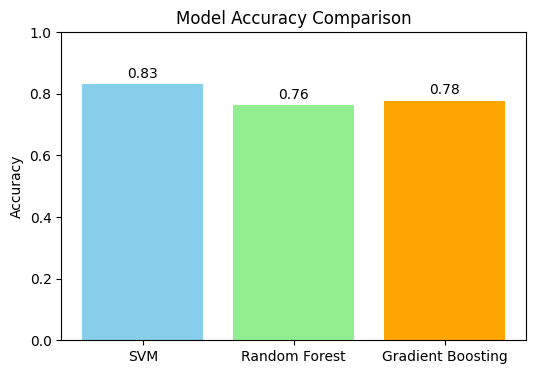

In [108]:
import matplotlib.pyplot as plt

models = ['SVM', 'Random Forest', 'Gradient Boosting']
accuracies = [
    accuracy_score(y_test, y_pred),        # SVM
    accuracy_score(y_test, y_pred_rf),     # RF
    accuracy_score(y_test, y_pred_gbm)     # GBM
]

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'orange'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')
plt.show()


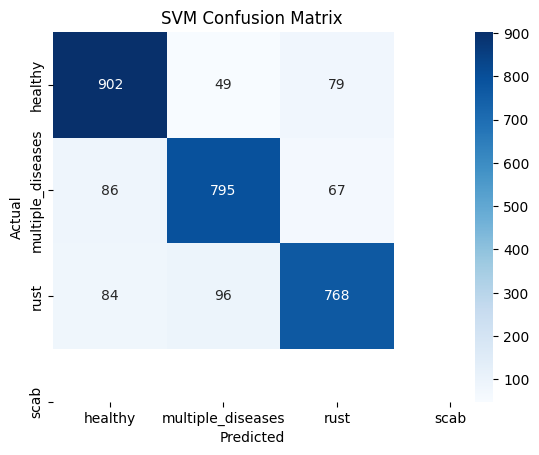

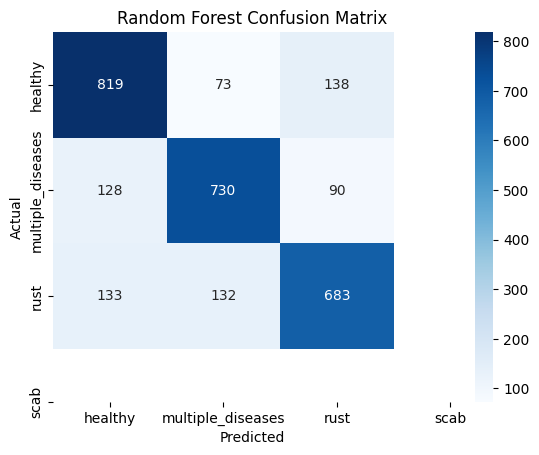

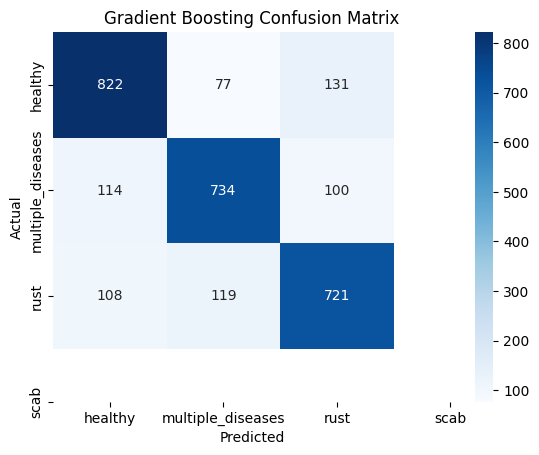

In [110]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_conf_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrices for all models
plot_conf_matrix(y_test, y_pred_svm, "SVM")
plot_conf_matrix(y_test, y_pred_rf, "Random Forest")
plot_conf_matrix(y_test, y_pred_gbm, "Gradient Boosting")

